## Framework para modelado generativo

El juego generativo:
* Escogi una regla para generar un conjunto de puntos ${\bf X}$
    * Llamemos a esta regla $p_{data}$
* El objetivo es escoger un punto diferente ${\bf x} = (x_1,x_2)$ en el espacio que parezca como si fue generado por la misma regla.

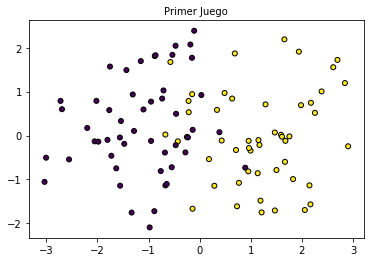

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs


plt.title("Primer Juego", fontsize='medium')
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k')

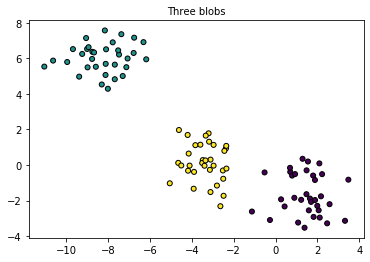

In [12]:
plt.title("Three blobs", fontsize='medium')
X1, Y1 = make_blobs(n_features=2, centers=3)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k')

* Probablemente usaron su conocimiento de los puntos existentes para construir un modelo mental, $p_{model}$ de donde es mas probable encontrar un punto.
* En este sentido, $p_{model}$ es un _estimado_ de $p_{data}$
* Para generar una nueva observacion, podemos escoger un punto aleatorio dentro del $p_{model}$
* Formalmente, _muestrear_ de la distribucion de $p_{model}$
* esto es un modelo generativo

### El Framework

* Tenemos un dataset de observaciones ${\bf X}$
* Asumimos que las observaciones han sido generadas de acuerdo a una distribucion desconocida, $p_{data}$
* Un modelo generativo $p_{model}$ trata de imitar $p_{data}$.
    * Si logramos esta meta, podemos muestrear de $p_{model}$ para generar observaciones que parezcan que fueron muestreadas de $p_{data}$
* Nos impresiona $p_{model}$ si:
    * Regla 1: Puede generar ejemplos que parecen ser muestreados de $p_{data}$
    * Regla 2: Puede generar ejemplos que son suficientemente diferentes a las observaciones en ${\bf X}$.

## Modelos Generativos Probabilisticos

* Para poder entender completamente la historia de los modelos que vamos a ver, vale la pena construir un modelo generativo que no depende de DL y en vez este fundamentado en teoria probabilistica pura.
* Esto nos provee un fundamento para entender cualquier modelo generativo, ya sea basado en DL o no, del mismo punto de vista probabilistico.
* Empezamos definiendo cuatro terminos clave: _sample space, density function, parametric modeling, maximum likelihood estimation_

### Sample Space

El _sample space_ es el conjunto completo de todos los valores que una observacion ${\bf x}$ puede tomar.

Por ejemplo, si nuestra data son puntos sobre el mundo, el sample space consiste en todos los puntos de latitud y longitud
${\bf x}=(x_1,x_2)$ en el mapa del mundo.

${\bf x}=(40.7306,-75.9352)$ es un punto en el sample space (NYC)

### Probability Density Function

Un _probability density function_ (o simplemente _density function_), $p({\bf x})$, es una funcion que mapea un punto ${\bf x}$ en el sample space a un numero entre 0 y 1.

La suma (la integral si el sample space es continuo) de la density function sobre todos los puntos en el sample space debe ser igual a 1, para que sea una distribucion de probabilidad bien definida.

Si el sample space es discreto, $p({\bf x})$ es simplemente la probabilidad asignada a observar un punto ${\bf x}$

Aunque solo hay una verdadera density function $p_{data}$ que asumimos genero el dataset observable, hay infinitas density functions $p_{model}$ que podemos usar para estimar $p_{data}$. 

Para poder estructurar nuestro enfoque a encontrar un $p_{model}({\bf X})$ adecuado, podemos usar una tecnica conocida como _parametric modeling_

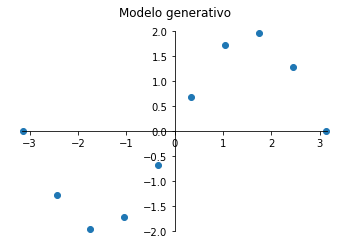

In [23]:
fig = plt.figure()
x = np.linspace(-np.pi, np.pi, 10)
y = 2 * np.sin(x)

ax = fig.add_subplot(1,1,1)
ax.set_title('Modelo generativo')
ax.scatter(x, y)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

### Parametric Modeling

Un _modelo parametrico_ $p_{\theta}({\bf x})$ es una famila de density functions que pueden ser descritas usando un numero finito de parametros, $\theta$

La familia de todas las posibles cajas que podrian dibujar es un ejemplo de un modelo parametrico

En este caso, existen cuatro parametros: las coordenadas de la esquina inferior izquierda $(\theta_1, \theta_2)$ y de la esquina superior derecha $(\theta_1, \theta_2)$

Por tanto, cada funcion de densidad $p_{\theta}(x)$ en este modelo parametrico (i.e., cada caja) puede ser representada de forma unica por cuatro numeros,

$\theta = (\theta_1, \theta_2, \theta_3, \theta_4)$

### Likelihood

El _likelihood_ $\mathcal{L}(\theta | x)$ de un conjunto de parametros $\theta$ es una funcion que mide la posibilidad de $\theta$, dado un punto observado $x$.

Se define de la siguiente forma:

$\mathcal{L}(\theta | x)=p_{theta}(x)$

Es decir, el likelihood de $\theta$ dado algun punto observado $x$ esta definido como el valor de la density function parametrizada por $\theta$, en el punto $x$

Si tenemos un dataset ${\bf X}$ de observaciones independientes podemos escribir:

$\mathcal{L}(\theta | {\bf X}) = \prod_{{\bf x} \in {\bf X}}p_{\theta}({\bf x})$

Como este producto puede ser computacionalmente dificil de calcular, en vez se utiliza el _log-likelihood_ $\mathcal{l}$:

$\mathcal{l}(\theta | {\bf X}) = \sum_{{\bf x} \in {\bf X}}\log p_{\theta}({\bf x})$

Hay razones estadisticas por las cuales el _likelihood_ esta definido de esta manera, pero para nosotros es suficiente entender intuitivamente porque hace sentido. Simplemente, estamos definiendo el likelihood de que un conjunto de parametros $\theta$ sea igual a la probabilidad de ver la data bajo el modelo parametrizado por $\theta$.

En el ejemplo de la funcion de $\sin$, un modelo que cubra las partes fuera de esos puntos tiene un likelihood de 0, ya que no es posible que haya generado el dataset. Un modelo que incluya puntos sobre la trayectoria del $\sin$ tiene un likelihood positivo ya que el density function es positivo para todos los puntos bajo este modelo.

Por tanto, hace sentido intuitivamente que el enfoque de un modelo parametrico sea encontrar el valor optimo de $\hat{\theta}$ del conjunto de parametros que maximiza el likelihood de observar el dataset ${\bf X}$. Esta tecnica se conoce como _maximum likelihood estimation_.

### Maximum Likelihood Estimation

_Maximum likelihood estimation_ es una tecnica que nos permite estimar $\hat{\theta}$: el conjunto de parametros $\theta$ de un density function, $p_{\theta}({\bf x})$ que con mas psobilidad explican alguna data observada ${\bf X}$.

Mas formal:

$\hat{\theta} = argmax_{\theta} \mathcal{L}(\theta | {\bf X})$

$\hat{\theta}$ tambien se conoce como _maximum likelihood estimate_ (MLE)

Con esto, tenemos la terminologia necesaria para poder describir como podemos construir un modelo generativo probabilisitico.